In [ ]:
import numpy as np
import torch
import torch.distributions as dists
from sklearn.model_selection import train_test_split
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import torch.nn as nn
import copy 
!pip install laplace-torch
from laplace.baselaplace import FullLaplace
from laplace.curvature.backpack import BackPackGGN
from laplace import Laplace, marglik_training

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cuda = torch.cuda.is_available()
print("CUDA USE OF GPU:", cuda)

CUDA USE OF GPU: False


In [4]:
# REGRESSION SIMULATED DATASET
def f(x, sigma_noise, heterothedastic, mask):
    y1 = np.sin(x)
    y2 = np.sin(2 * x)
    m = np.shape(x)[0]
    e = np.random.randn(m)[:, np.newaxis]
    s_noise = np.repeat(sigma_noise, m)[:, np.newaxis]
    y = 3*(y1+y2)
    if heterothedastic:
        mask1 = ((x < -2) & (x > -4)).flatten()
        s_noise[mask1] = 3*s_noise[mask1]
        
        mask2 = ((x > 1) & (x < 3)).flatten()
        s_noise[mask2] = 10 * s_noise[mask2]
    mask3 = (x < -5).flatten()
    s_noise[mask3] = 5*s_noise[mask3]
    y[mask3] = 5
    mask4 = (x > 5).flatten()
    y[mask4] = -5
    s_noise[mask4] = 5*s_noise[mask4]
    return y + s_noise*e

def SimRegressionDataset(xmin=-7, xmax=7, N=250, sigma_noise=0.5, batch_size=50, mask=False, seed=False, heter=False, shuffle=False, cuda=False):
    if seed:
        np.random.seed(70)
    X = np.linspace(xmin, xmax, N) + 0.2 * np.random.randn(N)
    X = X[:, np.newaxis]
    y = f(X, sigma_noise, heterothedastic=heter, mask=mask)
    X = np.array(X, dtype="float32")
    y = np.array(y, dtype="float32")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)
    if mask:
        mask_train = (((X_train > -5) & (X_train < 1)) | ((X_train > 3) & (X_train<5))).flatten()
        X_train = X_train[mask_train, :]
        y_train = y_train[mask_train]
    X_train, y_train, X_test, y_test = torch.from_numpy(X_train), torch.from_numpy(y_train), torch.from_numpy(
        X_test), torch.from_numpy(y_test)
    X_grid = np.linspace(xmin - 1, xmax + 1, 2 * N)[:, np.newaxis]
    X_grid = torch.from_numpy(np.array(X_grid, dtype="float32"))
    if cuda:
        X_train, X_test, y_train, y_test, X_grid = X_train.cuda(), X_test.cuda(), y_train.cuda(), y_test.cuda(), X_grid.cuda()
    train_loader = data_utils.DataLoader(data_utils.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=shuffle)
    test_loader = data_utils.DataLoader(data_utils.TensorDataset(X_test, y_test), batch_size=batch_size)
    return X_train, y_train, train_loader, X_test, y_test, test_loader, X_grid


def plot_regression(method, X_train, y_train, X_test, y_test, X_grid, mu, aleatoric, epistemic, title=None):
    X_train, y_train, X_test, y_test, X_grid = X_train.cpu().flatten(), y_train.cpu().flatten(), X_test.cpu().flatten(), \
                                               y_test.cpu().flatten(), X_grid.flatten().cpu().numpy()
    
    fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(10, 6))

    if method == "MAP":
        color, color2 = 'orange', 'tab:orange'
    elif method =="ENS":
        color, color2 = 'grey', 'tab:grey'
    elif method == "MC":
        color, color2 = 'blue', 'tab:blue'
    elif method == "LAP":
        color, color2 = 'green', 'tab:green'

    std = np.sqrt(aleatoric**2 + epistemic**2)
    # ax.set_title(title)
    ax.scatter(X_train, y_train, s=15, alpha=0.7, color='black')
    ax.scatter(X_test, y_test, s=15, alpha=0.7, color='red')
    ax.plot(X_grid, mu, color=color, label='$y_{PRED}$')
    ax.fill_between(X_grid, mu - 1.96*aleatoric, mu + 1.96*aleatoric,
                     alpha=0.1, color=color2, label='Aleatoric')
    if method != "MAP":
      ax.fill_between(X_grid, mu - 1.96 * std, mu - 1.96 * aleatoric,
                        alpha=0.2, color=color2, label='Epistemic')
      
    ax.fill_between(X_grid, mu + 1.96 * aleatoric, mu + 1.96 * std,
                     alpha=0.2, color=color2)
    ax.legend(loc='lower left', prop=dict(size=20))

    ax.set_ylim([y_test.min()-5, y_test.max()+5])
    ax.set_xlim([X_grid.min(), X_grid.max()])
    ax.set_ylabel('$y$')
    ax.set_xlabel('$x$')
    # ax.set_ylabel('$y$', fontsize=16)
    # ax.set_xlabel('$x$', fontsize=16)
    # ax.set_xticklabels(np.arange(-10, 10, 2), fontsize=15)
    # ax.set_yticklabels(np.arange(-15, 15, 5), fontsize=15)
    plt.tight_layout()
    plt.savefig(method)
    plt.show()

def test_metrics(y_pred, y_test, y_pred_std, name):
  nll = -dists.Normal(y_pred, y_pred_std).log_prob(y_test).mean()
  mse = criterion(y_pred, y_test)
  mae = criterion2(y_pred, y_test)
  title = f'[{name}] NLL: {nll:.3}, MSE: {mse:.3}, MAE: {mae:.3}'
  print(title)

def test_metrics_ood(y_pred, y_test, y_pred_std, test_ood, name):
  y_pred, y_test, y_pred_std = y_pred[test_ood],  y_test[test_ood], y_pred_std[test_ood]
  name = name + ' OOD'
  return test_metrics(y_pred, y_test, y_pred_std, name)

def test_metrics_id(y_pred, y_test, y_pred_std, test_id, name):
  y_pred, y_test, y_pred_std = y_pred[test_id],  y_test[test_id], y_pred_std[test_id]
  name = name + ' ID'
  return test_metrics(y_pred, y_test, y_pred_std, name)


def AUSE(abs_error, y_var):
    idx_errors = np.argsort(abs_error)[::-1]
    idx_variances = np.argsort(y_var)[::-1]
    scurve_errors = np.array([])
    scurve_variances = np.array([])
    abs_error_sorted = abs_error[idx_errors]
    variances_sorted = abs_error[idx_variances]
    for _ in range(len(abs_error)-1):
        abs_error_sorted = np.delete(abs_error_sorted, 0)
        scurve_errors = np.append(scurve_errors,np.mean(abs_error_sorted))
        variances_sorted = np.delete(variances_sorted,0)
        scurve_variances = np.append(scurve_variances, np.mean(variances_sorted))
    integral_errors = np.trapz(scurve_errors)
    integral_variances = np.trapz(scurve_variances)
    ause = np.abs(integral_errors - integral_variances)
    return scurve_errors, scurve_variances, ause

def PlotAuse(method, mu_MAP, var_MAP, y_test):
    if method == "MAP":
        color = 'tab:orange'
    elif method == "ENS":
        color = 'tab:grey'
    elif method == "MC":
        color = 'tab:blue'
    elif method == "LAP":
        color = 'tab:green'

    y_test, mu_MAP, var_MAP = y_test.numpy(), mu_MAP.numpy(), var_MAP.numpy()
    ae_MAP = np.abs(mu_MAP-y_test)
    scurve_errors_MAP, scurve_variances_MAP, ause_MAP = AUSE(ae_MAP, var_MAP)
    fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(10, 5))

    print(f'AUSE:{round(ause_MAP,2)}')
    ax.scatter(range(len(scurve_errors_MAP)), scurve_errors_MAP, color='blue', label='oracle')
    ax.scatter(range(len(scurve_errors_MAP)), scurve_variances_MAP, color='black', label='model')
    ax.fill_between(range(len(scurve_errors_MAP)), scurve_errors_MAP, scurve_variances_MAP,
                     alpha=0.2, color=color, label='AUSE')
    ax.legend(prop=dict(size=20))

    ax.set_ylabel('mae')
    ax.set_xlabel('samples removed')

    plt.tight_layout()
    plt.savefig(method + '_AUSE')
    plt.show()

In [5]:
# MODEL
class SimpleMLP(nn.Sequential):
    def __init__(self, input_size, h_size=10, n_layers=3, var_head=False, activation='tanh', dropout=False, transfer_off=False):
        self.trans_off = transfer_off
        self.activation = activation
        self.linear_model = (n_layers == 1)
        if n_layers == 1:  # linear model
            if var_head: super().__init__(nn.Linear(input_size, 2))
            else:  var_head: super().__init__(nn.Linear(input_size, 1))
        else:
            fc_in = nn.Linear(input_size, h_size)  # fc_in, first layer
            hidden_layers = nn.Sequential(*[nn.Sequential(nn.Linear(h_size, h_size), self.transfer()) for _ in range(n_layers - 2)])
            if var_head: 
              fc_out = nn.Linear(h_size, 2)
            else: 
              fc_out = nn.Linear(h_size, 1)  # fc_out, last layer

            if dropout:
                drop = nn.Dropout(p=0.25)
                super().__init__(fc_in, self.transfer(), hidden_layers, drop, fc_out)
            else:
                super().__init__(fc_in, self.transfer(), hidden_layers, fc_out)
    
    def transfer(self):
        if self.activation == 'tanh':
            return torch.nn.Tanh()
        elif self.activation == 'relu':
            return torch.nn.ReLU()
        elif self.activation == 'sigmoid':
            return torch.nn.Sigmoid()

    def weights(self):
      return torch.cat([p.flatten() for p in model.parameters()])

def init_weights(m):
  if isinstance(m, nn.Linear):
      torch.nn.init.xavier_uniform_(m.weight)
      m.bias.data.fill_(0.01)


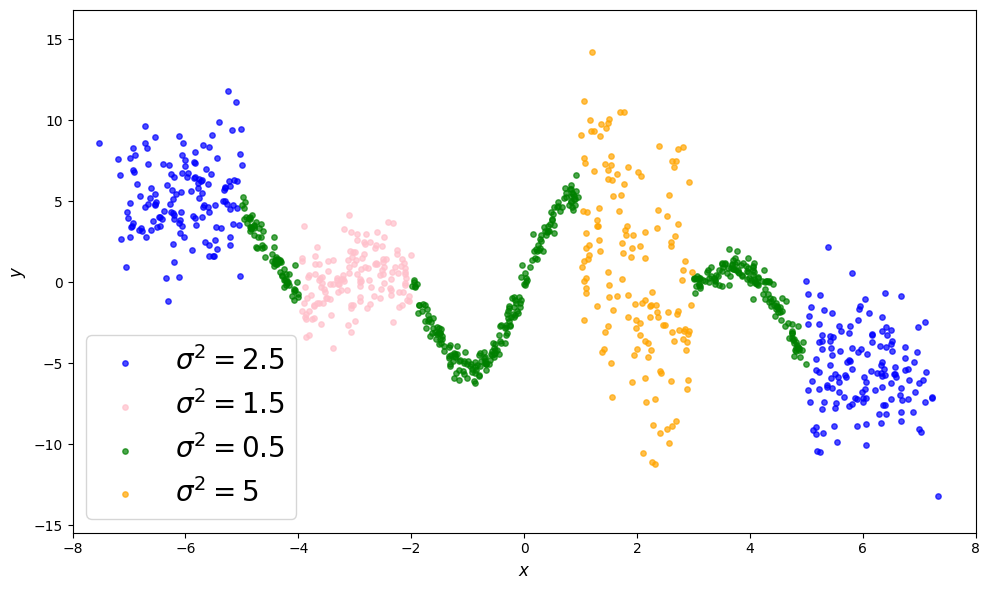

In [6]:
# torch.manual_seed(1380)
sigma_noise = 0.5
batch_size = 150
X_train, y_train, train_loader, X_test, y_test, test_loader, X_grid = SimRegressionDataset(N=1000, sigma_noise=sigma_noise, batch_size=batch_size,
                                                                                            mask=False, seed=True, heter=True, cuda=cuda)
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(10, 6))
X_full = np.vstack([X_train, X_test])
y_full = np.vstack([y_train, y_test])
X_sigma1 = X_full[(X_full < -5) | (X_full > 5)]
y_sigma1 = y_full[(X_full < -5) | (X_full > 5)]
X_sigma2 = X_full[(X_full < -2) & (X_full > -4)]
y_sigma2 = y_full[(X_full < -2) & (X_full > -4)]
X_sigma3 = X_full[((X_full < -4) & (X_full > -5)) | ((X_full < 1) & (X_full > -2)) | ((X_full < 5) & (X_full > 3))]
y_sigma3 = y_full[((X_full < -4) & (X_full > -5)) | ((X_full < 1) & (X_full > -2)) | ((X_full < 5) & (X_full > 3))]
X_sigma4 = X_full[(X_full < 3) & (X_full > 1)]
y_sigma4 = y_full[(X_full < 3) & (X_full > 1)]
ax.scatter(X_sigma1, y_sigma1, s=15, alpha=0.7, color='blue', label='$\sigma^2=2.5$')
ax.scatter(X_sigma2, y_sigma2, s=15, alpha=0.7, color='pink', label='$\sigma^2=1.5$')
ax.scatter(X_sigma3, y_sigma3, s=15, alpha=0.7, color='green', label='$\sigma^2=0.5$')
ax.scatter(X_sigma4, y_sigma4, s=15, alpha=0.7, color='orange', label='$\sigma^2=5$')
ax.legend(loc='lower left', prop=dict(size=20))

ax.set_ylim([y_test.min()-5, y_test.max()+5])
ax.set_xlim([X_grid.min(), X_grid.max()])
ax.set_ylabel('$y$', fontsize=12)
ax.set_xlabel('$x$', fontsize=12)
# ax.set_xticklabels(np.arange(-10, 10, 2), fontsize=15)
# ax.set_yticklabels(np.arange(-15, 15, 5), fontsize=15)
plt.tight_layout()
plt.savefig('DatasetSigmas')
plt.show()

In [7]:
X_train, y_train, train_loader, X_test, y_test, test_loader, X_grid = SimRegressionDataset(N=750, sigma_noise=sigma_noise, batch_size=batch_size,
                                                                                            mask=True, seed=True, heter=True, cuda=cuda)
test_ood = [(X_test < -5) | (X_test > 5) | ((X_test < 3) & (X_test > 1))]
test_id =  [(X_test < -5) | (X_test > 5) | ((X_test < 3) & (X_test > 1))]
test_id[0] = torch.from_numpy(np.invert(test_id[0].numpy()))

test_ood[0] = test_ood[0].squeeze()
test_id[0] = test_id[0].squeeze()
y_test = y_test.squeeze().cpu()

prior_prec = 5
n_epochs = 500

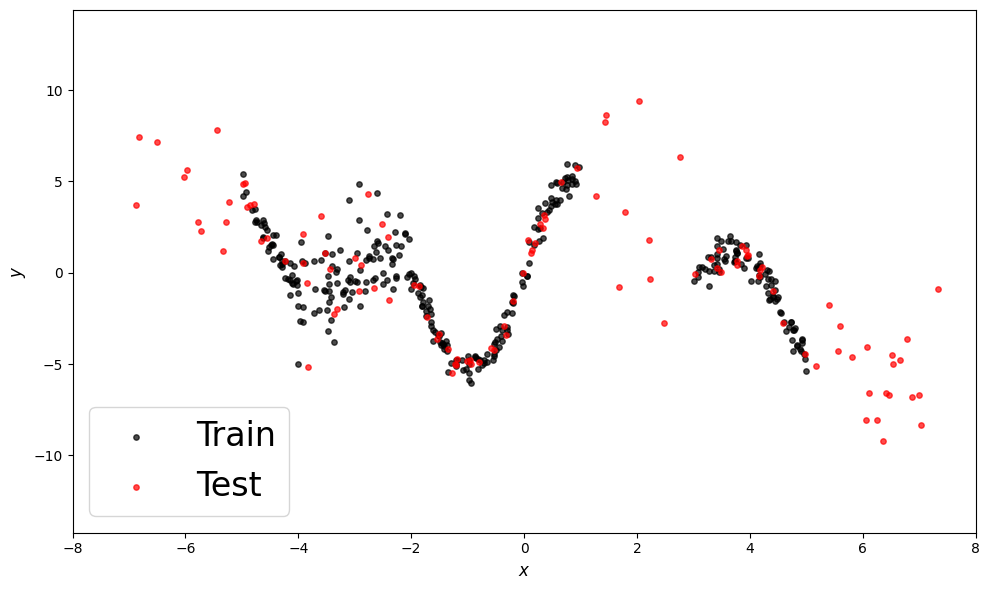

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(10, 6))
ax.scatter(X_train, y_train, s=15, alpha=0.7, color='black', label='Train')
ax.scatter(X_test, y_test, s=15, alpha=0.7, color='red', label='Test')
ax.legend(loc='lower left', prop=dict(size=24))

ax.set_ylim([y_test.min()-5, y_test.max()+5])
ax.set_xlim([X_grid.min(), X_grid.max()])
ax.set_ylabel('$y$', fontsize=12)
ax.set_xlabel('$x$', fontsize=12)
plt.tight_layout()
plt.savefig('Dataset')
plt.show()

In [11]:
# create and train MAP model
in_size = X_train.shape[1]
n_layers = 3
h_size = 25
prior_prec = 0.2
prior_std = np.sqrt(1/prior_prec)

var_head = True
if cuda:
    model = SimpleMLP(input_size=in_size, h_size=h_size, n_layers=n_layers, var_head = var_head, activation='tanh').cuda()
else:
    model = SimpleMLP(input_size=in_size, h_size=h_size, n_layers=n_layers, var_head = var_head, activation='tanh')

criterion = torch.nn.MSELoss()
criterion2 = torch.nn.L1Loss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
prior = dists.Normal(0, prior_std)
for i in range(n_epochs):
    for X, y in train_loader:
        optimizer.zero_grad()
        output = model(X)
        if var_head:
          mu = torch.unsqueeze(output[:, 0], dim=-1)
          logvar = torch.unsqueeze(output[:, 1], dim=-1)
          st_dev = torch.exp(logvar).sqrt()
        else:
          mu = output
          st_dev = np.sqrt(sigma_noise)
        likelihood = dists.Normal(mu, st_dev)
        loss1 = - torch.sum(likelihood.log_prob(y))
        loss2 = - torch.sum(prior.log_prob(model.weights()))
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()

[MAP] NLL: 9.48, MSE: 5.58, MAE: 1.54
[MAP OOD] NLL: 24.2, MSE: 13.1, MAE: 3.02
[MAP ID] NLL: 1.1, MSE: 1.29, MAE: 0.7


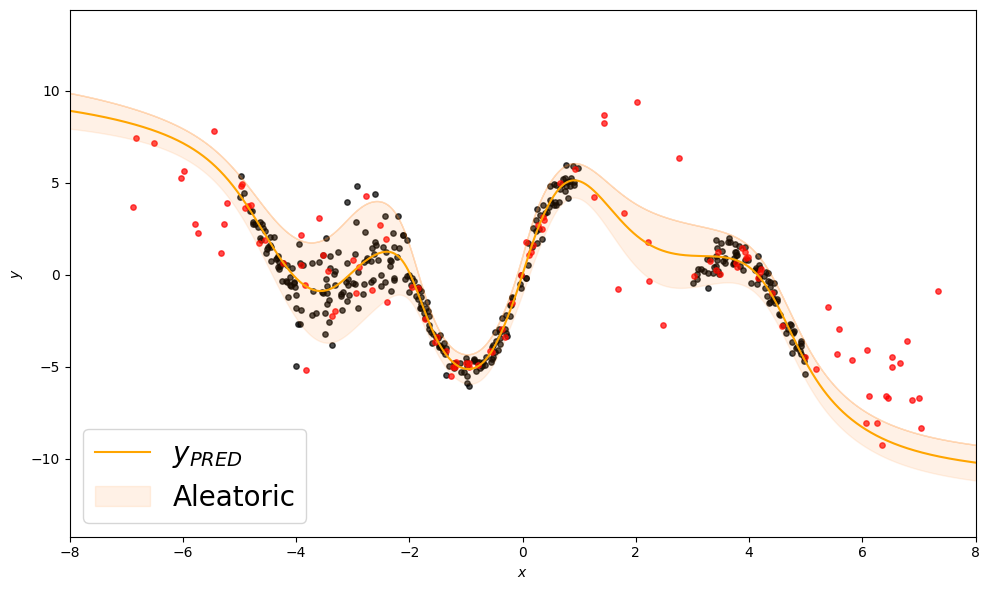

AUSE:103.05


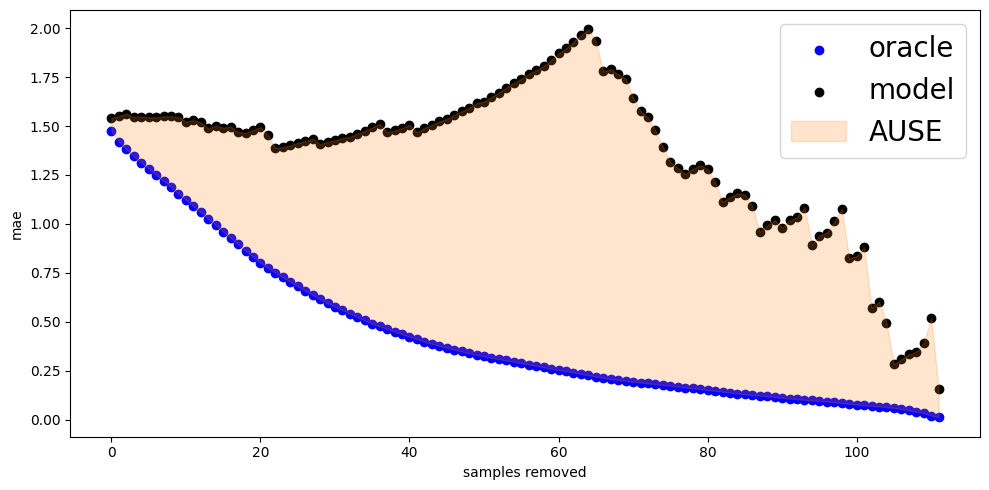

In [61]:

# Test MAP model
y_test = y_test.squeeze()
y_mu_MAP = model(X_test)[:, 0].detach().cpu()
if var_head:
  y_logvar_MAP = model(X_test)[:, 1].detach().cpu()
  pred_std_MAP = torch.exp(y_logvar_MAP).sqrt()
else:
  pred_std_MAP = sigma_noise*torch.ones_like(y_mu_MAP)

test_metrics(y_mu_MAP, y_test, pred_std_MAP, 'MAP')
test_metrics_ood(y_mu_MAP, y_test, pred_std_MAP, test_ood, 'MAP')
test_metrics_id(y_mu_MAP, y_test, pred_std_MAP, test_id, 'MAP')

# Plot MAP model
mu_GRID = model(X_grid)
f_mu_GRID = mu_GRID[:, 0].squeeze().detach().cpu().numpy()
if var_head:
  y_logvar_aleatoric_GRID_MAP = mu_GRID[:, 1].squeeze().detach().cpu()
  y_std_aleatoric_GRID_MAP = torch.exp(y_logvar_aleatoric_GRID_MAP).sqrt().numpy()
else:
  y_std_aleatoric_GRID_MAP = sigma_noise * np.ones_like(f_mu_GRID)

y_std_epistemic_GRID_MAP = np.zeros_like(f_mu_GRID)

plot_regression("MAP", X_train, y_train, X_test, y_test, X_grid, f_mu_GRID, y_std_aleatoric_GRID_MAP, y_std_epistemic_GRID_MAP)
PlotAuse("MAP", y_mu_MAP, pred_std_MAP**2, y_test)
# PlotAuse("MAP", y_mu_MAP[test_ood], pred_std_MAP[test_ood]**2, y_test[test_ood])

In [12]:
laplace_model = copy.deepcopy(model)
laplace_model[-1] =  nn.Linear(h_size, 1)
with torch.no_grad():
    laplace_model[-1].weight[0].copy_(model[-1].weight[0])
    laplace_model[-1].bias[0].copy_(model[-1].bias[0])

In [49]:
# Fit Laplace model
n_eps = 20
la = Laplace(laplace_model, 'regression', subset_of_weights='all', hessian_structure='full')
la.fit(train_loader)
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(n_eps):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

[LAP] NLL: 1.81, MSE: 4.63, MAE: 1.38
[LAP OOD] NLL: 3.1, MSE: 10.5, MAE: 2.61
[LAP ID] NLL: 1.07, MSE: 1.27, MAE: 0.687


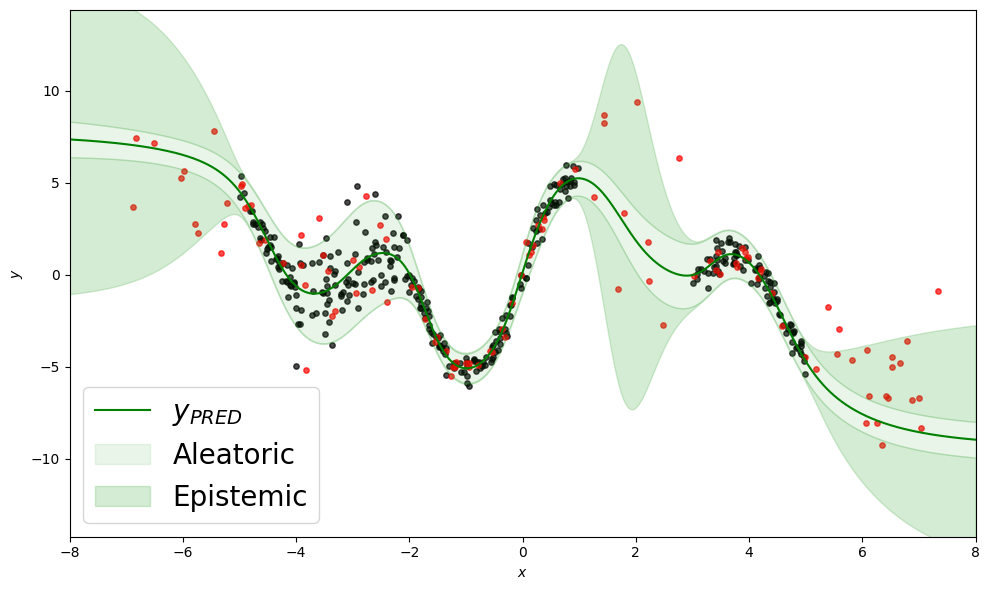

AUSE:26.17


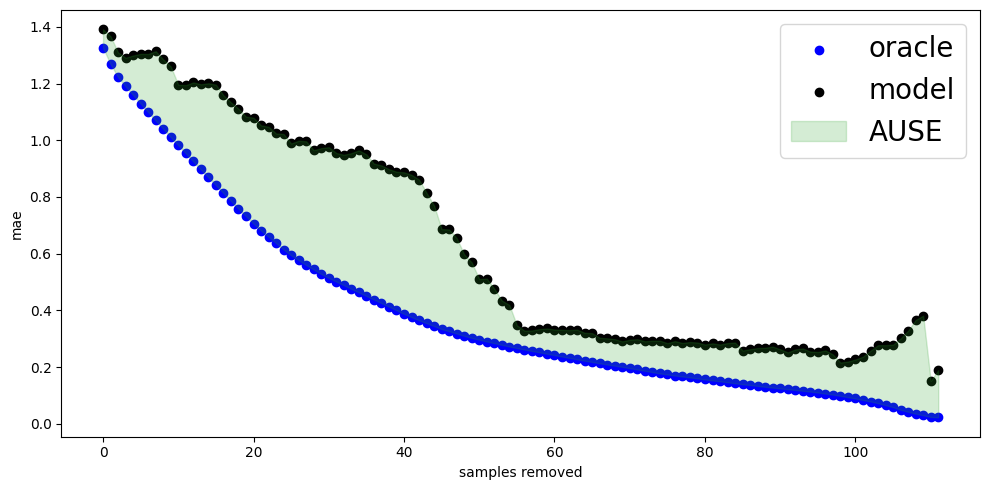

In [52]:
# Test Laplace Model
mu_LAP, var_LAP = la(X_test, pred_type='glm')
y_pred_LAP = mu_LAP[:, 0].detach().cpu()
y_var_epistemic_LAP = var_LAP[:, 0, 0].detach().cpu()
if var_head:
  y_logvar_aleatoric_LAP = model(X_test)[:, 1].detach().cpu()
  y_var_aleatoric_LAP = torch.exp(y_logvar_aleatoric_LAP)
else:
  y_var_aleatoric_LAP = la.sigma_noise.item() ** 2

y_pred_std_LAP = np.sqrt(y_var_epistemic_LAP + y_var_aleatoric_LAP)

test_metrics(y_pred_LAP, y_test, y_pred_std_LAP, 'LAP')
test_metrics_ood(y_pred_LAP, y_test, y_pred_std_LAP, test_ood, 'LAP')
test_metrics_id(y_pred_LAP, y_test, y_pred_std_LAP, test_id, 'LAP')

# Plot Laplace Model
mu_GRID_LAP, var_GRID_LAP = la(X_grid, pred_type='glm')
y_mu_GRID_LAP = mu_GRID_LAP[:, 0].squeeze().detach().cpu().numpy()
y_std_epistemic_GRID_LAP = var_GRID_LAP[:, 0, 0].squeeze().cpu().sqrt().numpy()
if var_head:
  y_logvar_aleatoric_GRID_LAP = model(X_grid)[:, 1].detach().cpu()
  y_std_aleatoric_GRID_LAP = torch.exp(y_logvar_aleatoric_GRID_LAP).sqrt().numpy()
else:
  y_std_aleatoric_GRID_LAP = la.sigma_noise.item() * np.ones_like(y_std_epistemic_GRID_LAP)


plot_regression("LAP", X_train, y_train, X_test, y_test, X_grid, y_mu_GRID_LAP, y_std_aleatoric_GRID_LAP, y_std_epistemic_GRID_LAP)
PlotAuse("LAP", y_pred_LAP, y_pred_std_LAP**2, y_test)
# PlotAuse("LAP", y_pred_LAP[test_ood], y_pred_std_LAP[test_ood]**2, y_test[test_ood])

In [53]:
# Fit Laplace model
n_eps = 20
la = Laplace(laplace_model, 'regression', subset_of_weights='last_layer', hessian_structure='full')
la.fit(train_loader)
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in range(n_eps):
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

[LAP] NLL: 3.77, MSE: 4.63, MAE: 1.38
[LAP OOD] NLL: 8.52, MSE: 10.5, MAE: 2.61
[LAP ID] NLL: 1.07, MSE: 1.27, MAE: 0.687


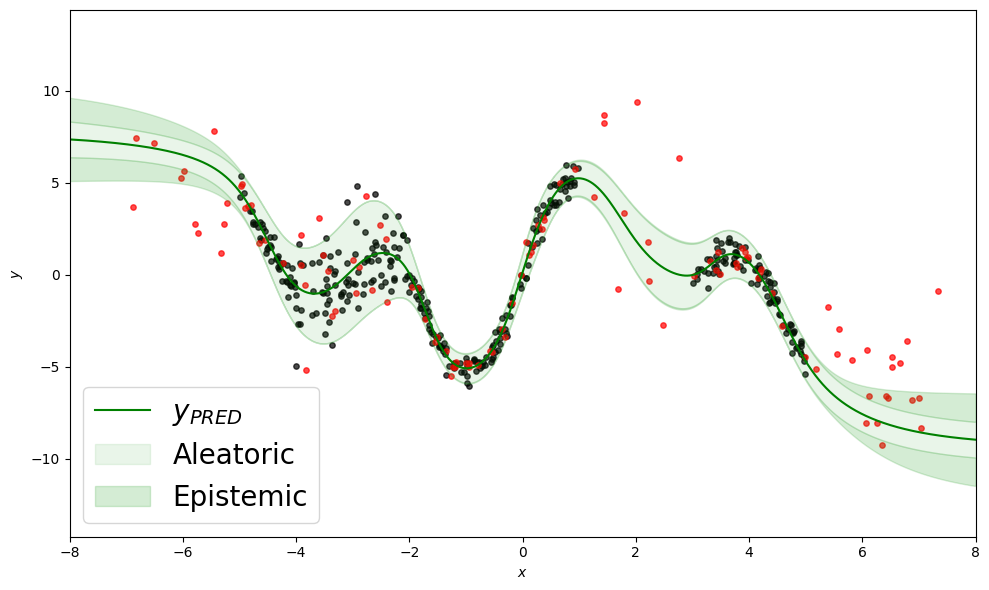

AUSE:38.23


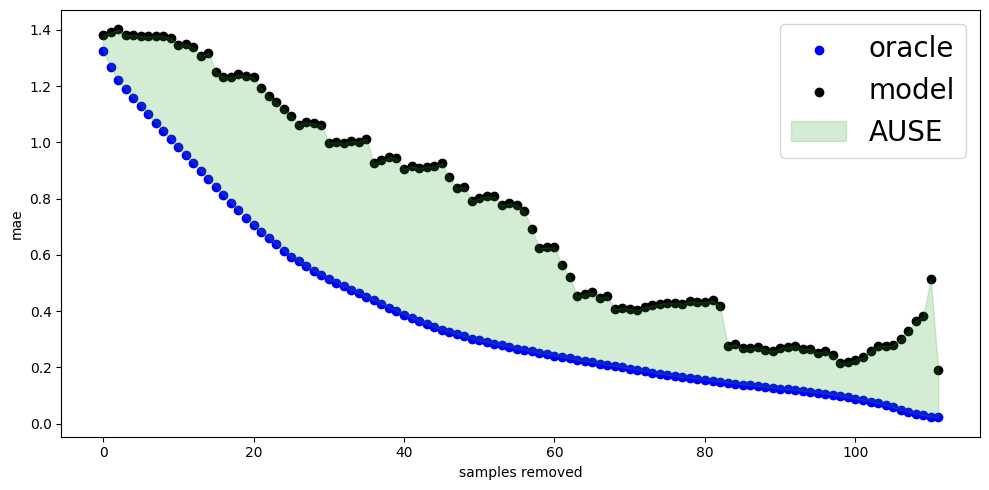

In [55]:
# Test Laplace Model
mu_LAP, var_LAP = la(X_test, pred_type='glm')
y_pred_LAP = mu_LAP[:, 0].detach().cpu()
y_var_epistemic_LAP = var_LAP[:, 0, 0].detach().cpu()
if var_head:
  y_logvar_aleatoric_LAP = model(X_test)[:, 1].detach().cpu()
  y_var_aleatoric_LAP = torch.exp(y_logvar_aleatoric_LAP)
else:
  y_var_aleatoric_LAP = la.sigma_noise.item() ** 2

y_pred_std_LAP = np.sqrt(y_var_epistemic_LAP + y_var_aleatoric_LAP)

test_metrics(y_pred_LAP, y_test, y_pred_std_LAP, 'LAP')
test_metrics_ood(y_pred_LAP, y_test, y_pred_std_LAP, test_ood, 'LAP')
test_metrics_id(y_pred_LAP, y_test, y_pred_std_LAP, test_id, 'LAP')

# Plot Laplace Model
mu_GRID_LAP, var_GRID_LAP = la(X_grid, pred_type='glm')
y_mu_GRID_LAP = mu_GRID_LAP[:, 0].squeeze().detach().cpu().numpy()
y_std_epistemic_GRID_LAP = var_GRID_LAP[:, 0, 0].squeeze().cpu().sqrt().numpy()
if var_head:
  y_logvar_aleatoric_GRID_LAP = model(X_grid)[:, 1].detach().cpu()
  y_std_aleatoric_GRID_LAP = torch.exp(y_logvar_aleatoric_GRID_LAP).sqrt().numpy()
else:
  y_std_aleatoric_GRID_LAP = la.sigma_noise.item() * np.ones_like(y_std_epistemic_GRID_LAP)


plot_regression("LAP", X_train, y_train, X_test, y_test, X_grid, y_mu_GRID_LAP, y_std_aleatoric_GRID_LAP, y_std_epistemic_GRID_LAP)
PlotAuse("LAP", y_pred_LAP, y_pred_std_LAP**2, y_test)
# PlotAuse("LAP", y_pred_LAP[test_ood], y_pred_std_LAP[test_ood]**2, y_test[test_ood])

In [13]:
# Fit Laplace model
n_eps = 20
from laplace.utils import LargestMagnitudeSubnetMask
subnetwork_mask = LargestMagnitudeSubnetMask(laplace_model, n_params_subnet=200)
subnetwork_indices = subnetwork_mask.select()
la = Laplace(laplace_model, 'regression', subset_of_weights='subnetwork', hessian_structure='full', subnetwork_indices=subnetwork_indices)
la.fit(train_loader)
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)

[LAP] NLL: 1.85, MSE: 4.63, MAE: 1.38
[LAP OOD] NLL: 3.01, MSE: 10.5, MAE: 2.61
[LAP ID] NLL: 1.19, MSE: 1.27, MAE: 0.687


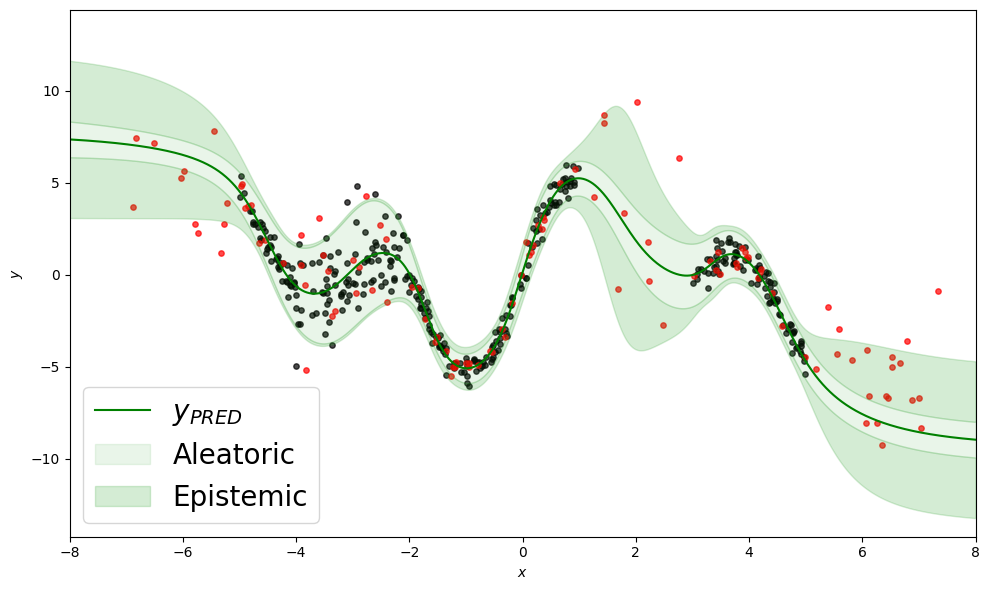

AUSE:24.42


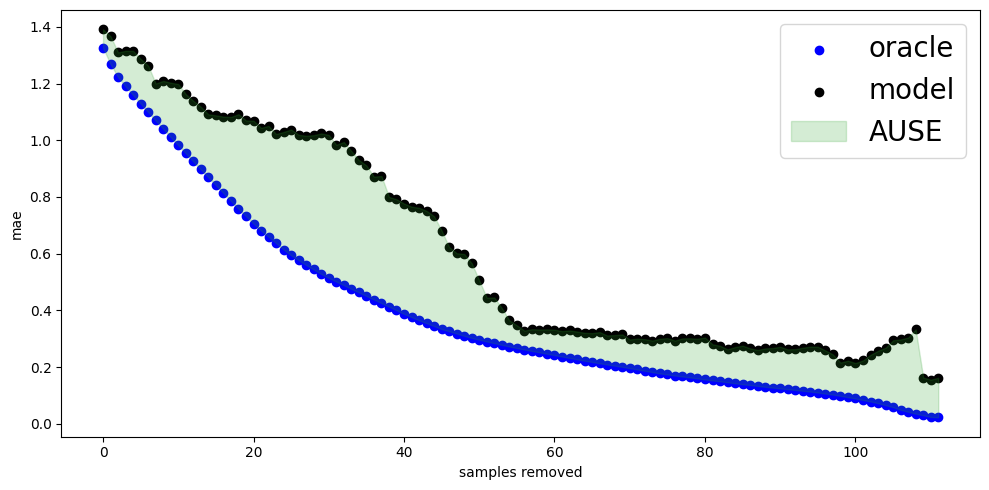

In [60]:
# Test Laplace Model
mu_LAP, var_LAP = la(X_test, pred_type='glm')
y_pred_LAP = mu_LAP[:, 0].detach().cpu()
y_var_epistemic_LAP = var_LAP[:, 0, 0].detach().cpu()
if var_head:
  y_logvar_aleatoric_LAP = model(X_test)[:, 1].detach().cpu()
  y_var_aleatoric_LAP = torch.exp(y_logvar_aleatoric_LAP)
else:
  y_var_aleatoric_LAP = la.sigma_noise.item() ** 2

y_pred_std_LAP = np.sqrt(y_var_epistemic_LAP + y_var_aleatoric_LAP)

test_metrics(y_pred_LAP, y_test, y_pred_std_LAP, 'LAP')
test_metrics_ood(y_pred_LAP, y_test, y_pred_std_LAP, test_ood, 'LAP')
test_metrics_id(y_pred_LAP, y_test, y_pred_std_LAP, test_id, 'LAP')

# Plot Laplace Model
mu_GRID_LAP, var_GRID_LAP = la(X_grid, pred_type='glm')
y_mu_GRID_LAP = mu_GRID_LAP[:, 0].squeeze().detach().cpu().numpy()
y_std_epistemic_GRID_LAP = var_GRID_LAP[:, 0, 0].squeeze().cpu().sqrt().numpy()
if var_head:
  y_logvar_aleatoric_GRID_LAP = model(X_grid)[:, 1].detach().cpu()
  y_std_aleatoric_GRID_LAP = torch.exp(y_logvar_aleatoric_GRID_LAP).sqrt().numpy()
else:
  y_std_aleatoric_GRID_LAP = la.sigma_noise.item() * np.ones_like(y_std_epistemic_GRID_LAP)


plot_regression("LAP", X_train, y_train, X_test, y_test, X_grid, y_mu_GRID_LAP, y_std_aleatoric_GRID_LAP, y_std_epistemic_GRID_LAP)
PlotAuse("LAP", y_pred_LAP, y_pred_std_LAP**2, y_test)
# PlotAuse("LAP", y_pred_LAP[test_ood], y_pred_std_LAP[test_ood]**2, y_test[test_ood])

In [45]:
# Fit ENSEMBLES model
n_models = 10
models = []

# Fit model
for j in range(n_models):
    torch.random.initial_seed()
    base_model = SimpleMLP(input_size=in_size, h_size=h_size, n_layers=3, var_head=var_head, activation='tanh')
    base_model.apply(init_weights)
    if cuda:
      base_model = base_model.cuda()
    model = copy.deepcopy(base_model)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    for i in range(n_epochs):
      for X, y in train_loader:
        optimizer.zero_grad()
        output = model(X)
        if var_head:
          mu = torch.unsqueeze(output[:, 0], dim=-1)
          logvar = torch.unsqueeze(output[:, 1], dim=-1)
          st_dev = torch.exp(logvar).sqrt()
        else:
          mu = output
          st_dev = np.sqrt(sigma_noise)
        likelihood = dists.Normal(mu, st_dev)
        loss1 = - torch.sum(likelihood.log_prob(y))
        loss2 = - torch.sum(prior.log_prob(model.weights()))
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
    models.append(model)

[ENSEMBLES (10)] NLL: 2.86, MSE: 3.99, MAE: 1.29
[ENSEMBLES (10) OOD] NLL: 5.98, MSE: 8.67, MAE: 2.3
[ENSEMBLES (10) ID] NLL: 1.09, MSE: 1.32, MAE: 0.71


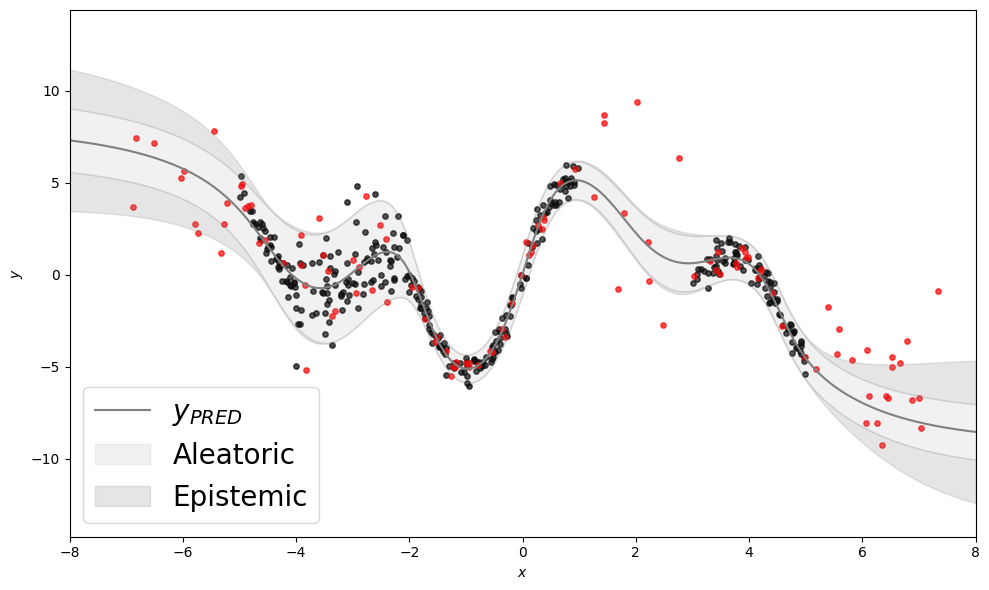

AUSE:39.45


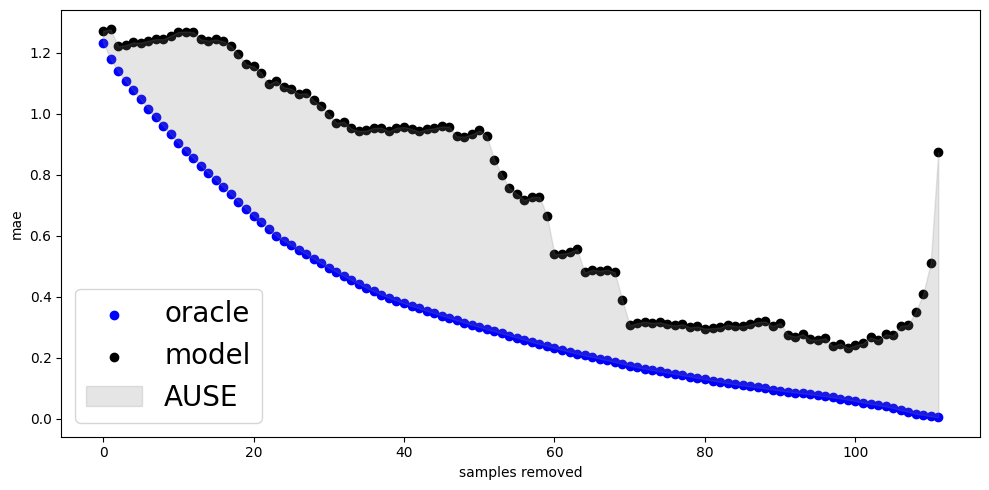

In [58]:
# Test model
mu, std = [], []
for model in models:
    y_mu = model(X_test)[:, 0].detach().cpu().numpy()
    mu.append(y_mu)
    if var_head:
      y_logvar = model(X_test)[:, 1].detach().cpu()
      y_std = torch.exp(y_logvar).sqrt().numpy()
    else:
      y_std = sigma_noise*np.ones_like(y_mu)
    std.append(y_std)

y_pred_ensembles = torch.from_numpy(np.mean(np.asarray(mu), axis=0))
y_std_epistemic_ensembles = np.std(np.asarray(mu), axis=0)
y_std_aleatoric_ensembles = np.mean(np.asarray(std), axis=0)
y_pred_std_ensembles = torch.from_numpy(np.sqrt(y_std_aleatoric_ensembles**2 + y_std_epistemic_ensembles**2))

test_metrics(y_pred_ensembles, y_test, y_pred_std_ensembles, f'ENSEMBLES ({n_models})')
test_metrics_ood(y_pred_ensembles, y_test, y_pred_std_ensembles, test_ood, f'ENSEMBLES ({n_models})')
test_metrics_id(y_pred_ensembles, y_test, y_pred_std_ensembles, test_id, f'ENSEMBLES ({n_models})')

# Plot
mu_GRID, std_GRID = [], []
for model in models:
    y_mu_GRID = model(X_grid)[:, 0].detach().cpu().numpy()
    mu_GRID.append(y_mu_GRID)
    if var_head:
      y_logvar = model(X_grid)[:, 1].detach().cpu()
      y_std_GRID = torch.exp(y_logvar).sqrt().numpy()
    else:
      y_std_GRID = sigma_noise*np.ones_like(y_mu_GRID)
    std_GRID.append(y_std_GRID)


y_mu_GRID_ensembles = np.mean(np.asarray(mu_GRID), axis=0)
y_std_epistemic_GRID_ensembles = np.std(np.asarray(mu_GRID), axis=0)
y_std_aleatoric_GRID_ensembles = np.mean(np.asarray(std_GRID), axis=0)

plot_regression("ENS", X_train, y_train, X_test, y_test, X_grid, y_mu_GRID_ensembles, y_std_aleatoric_GRID_ensembles, y_std_epistemic_GRID_ensembles)
PlotAuse("ENS", y_pred_ensembles, y_pred_std_ensembles**2, y_test)
# PlotAuse("ENS", y_pred_ensembles[test_ood], y_pred_std_ensembles[test_ood]**2, y_test[test_ood])

In [47]:
# MC-DROPOUT
forward_passes = 10

# Fit model
if cuda:
  model_MC = SimpleMLP(input_size=in_size, h_size=h_size, n_layers=3,  var_head=var_head, activation='tanh', dropout=True).cuda()
else:
  model_MC = SimpleMLP(input_size=in_size, h_size=h_size, n_layers=3,  var_head=var_head, activation='tanh', dropout=True)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model_MC.parameters(), lr=1e-2)
for i in range(4*n_epochs):
    for X, y in train_loader:
        optimizer.zero_grad()
        output = model_MC(X)
        if var_head:
          mu = torch.unsqueeze(output[:, 0], dim=-1)
          logvar = torch.unsqueeze(output[:, 1], dim=-1)
          st_dev = torch.exp(logvar).sqrt()
          # print(mu.shape)
          # print(st_dev.shape)
        else:
          mu = output
          st_dev = np.sqrt(sigma_noise)
        likelihood = dists.Normal(mu, st_dev)
        loss1 = - torch.sum(likelihood.log_prob(y))
        loss2 = - torch.sum(prior.log_prob(model.weights()))
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()

[MC-DROP (10)] NLL: 2.54, MSE: 4.6, MAE: 1.36
[MC-DROP (10) OOD] NLL: 4.82, MSE: 10.4, MAE: 2.51
[MC-DROP (10) ID] NLL: 1.24, MSE: 1.31, MAE: 0.708


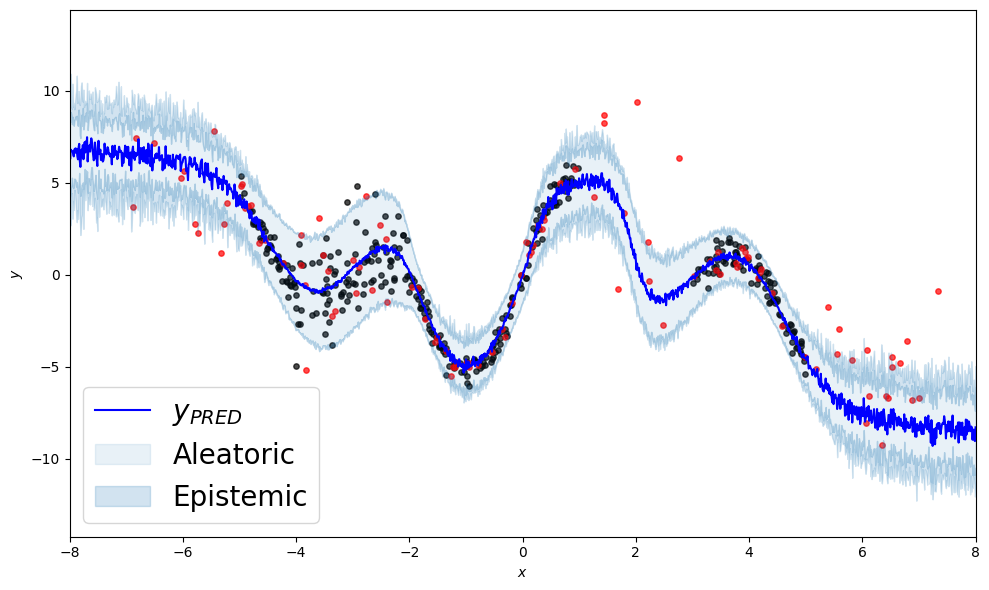

AUSE:43.73


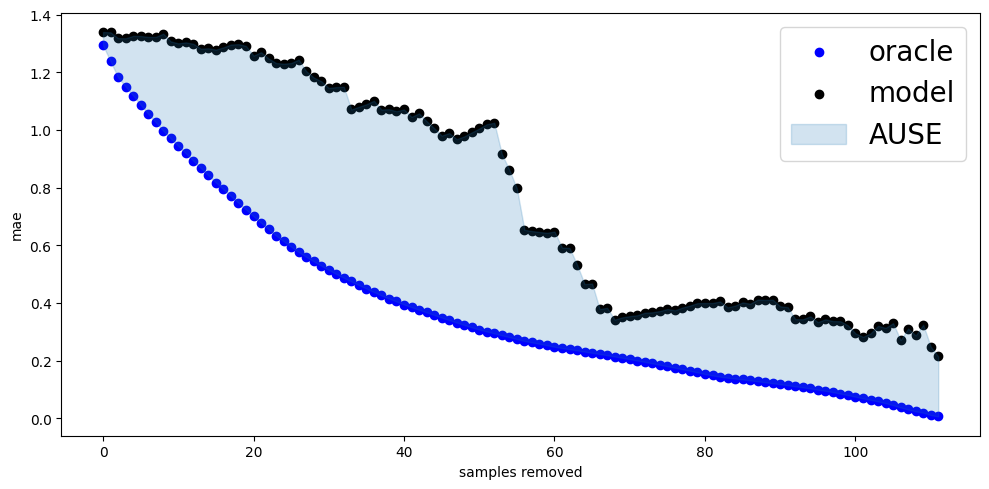

In [59]:
# Test
mu, std = [], []
for k in range(forward_passes):
    y_mu = model_MC(X_test)[:, 0].detach().cpu().numpy()
    mu.append(y_mu)
    if var_head:
      y_logvar = model_MC(X_test)[:, 1].detach().cpu()
      y_std = torch.exp(y_logvar).sqrt().numpy()
    else:
      y_std = sigma_noise*np.ones_like(y_mu)
    std.append(y_std)


y_pred_MC = torch.from_numpy(np.mean(np.asarray(mu), axis=0))
y_std_epistemic_MC = np.std(np.asarray(mu), axis=0)
y_std_aleatoric_MC = np.mean(np.asarray(std), axis=0)
y_pred_std_MC = torch.from_numpy(np.sqrt(y_std_aleatoric_MC**2 + y_std_epistemic_MC**2))

test_metrics(y_pred_MC, y_test, y_pred_std_MC, f'MC-DROP ({forward_passes})')
test_metrics_ood(y_pred_MC, y_test, y_pred_std_MC, test_ood, f'MC-DROP ({forward_passes})')
test_metrics_id(y_pred_MC, y_test, y_pred_std_MC, test_id, f'MC-DROP ({forward_passes})')

# Plot
mu_GRID, std_GRID = [], []
for model in models:
    y_mu_GRID = model_MC(X_grid)[:, 0].detach().cpu().numpy()
    mu_GRID.append(y_mu_GRID)
    if var_head:
      y_logvar = model_MC(X_grid)[:, 1].detach().cpu()
      y_std_GRID = torch.exp(y_logvar).sqrt().numpy()
    else:
      y_std_GRID = sigma_noise*np.ones_like(y_mu_GRID)
    std_GRID.append(y_std_GRID)


y_mu_MC_GRID = np.mean(np.asarray(mu_GRID), axis=0)
y_std_epistemic_MC_GRID = np.std(np.asarray(mu_GRID), axis=0)
y_std_aleatoric_MC_GRID = np.mean(np.asarray(std_GRID), axis=0)

plot_regression("MC", X_train, y_train, X_test, y_test, X_grid, y_mu_MC_GRID, y_std_aleatoric_MC_GRID, y_std_epistemic_MC_GRID)
PlotAuse("MC", y_pred_MC, y_pred_std_MC**2, y_test)
# PlotAuse("MC", y_pred_MC[test_ood], y_pred_std_MC[test_ood]**2, y_test[test_ood])